<a href="https://colab.research.google.com/github/avantika-14/machinelearning/blob/main/Deep_Fake_Voice_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'deep-voice-deepfake-voice-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3579787%2F6358196%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T125237Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D43c0c1bb6a2a6744774fe11854080a1140b7c880cbcb8111bd515591e1c1af09de31368d012124a0851d509d61a9965a1c44e954e4da14467cbad768d8066a42e7b522243288a75fdfb0cd87f580f85d9aab916453899e84ad62fcf435a4b174c3d541a6282c2fbc58dc0fb89701ecf1a0f0442df0ff23646da4ec5de4bdcc791d237fe0a953863f7951095538a0057cc3bd11744e10f4ddbb87aecb275d628b898a870a40e5dc84f3cc8f42394d0c5089b8088b8e0802803a9042f699fddcb1f6029433e5614947b50aea76d4242e1c1b5ec05a5c95259d2b6289f481f65f634e9fc262172564883e602581d6df57ce404c7f59974b72a334d30c0253edbbea'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3956840339 bytes downloaded
Downloaded and uncompressed: deep-voice-deepfake-voice-recognition
Data source import complete.


In [2]:

import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/linus-to-ryan.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-biden.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/obama-to-taylor.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/biden-to-margot.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/musk-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/linus-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-linus.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/linus-to-obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/biden-to-Obama.wav
/kaggle/input/deep-voice-deepf

# Import Libraries

In [3]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Load Data

In [5]:
audio_files_path = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/"

In [6]:
folders = os.listdir(audio_files_path)
print(folders)

['FAKE', 'REAL']


In [7]:
real_audio = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

# Visualization

In [8]:
print("Real Audio:")
IPython.display.Audio(real_audio)

Real Audio:


In [9]:
print("Fake Audio:")
IPython.display.Audio(fake_audio)

Fake Audio:


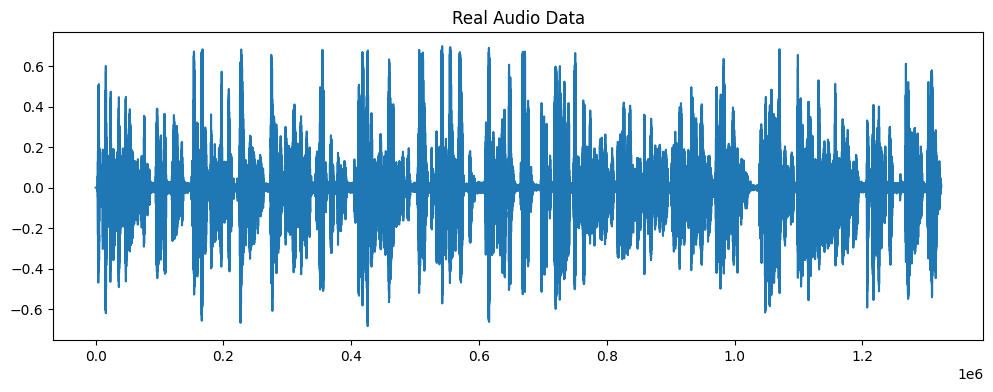

In [10]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize=(12, 4))
plt.plot(real_ad)
plt.title("Real Audio Data")
plt.show()

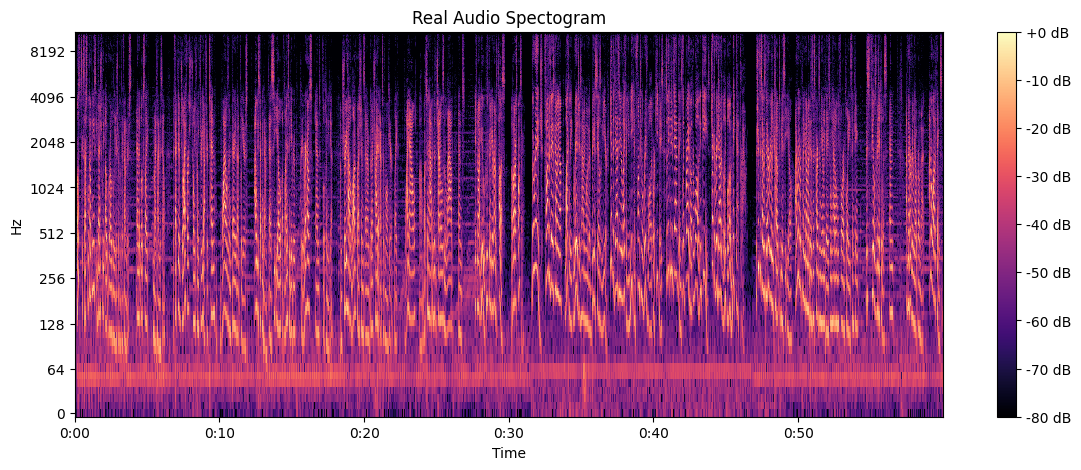

In [11]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.show()

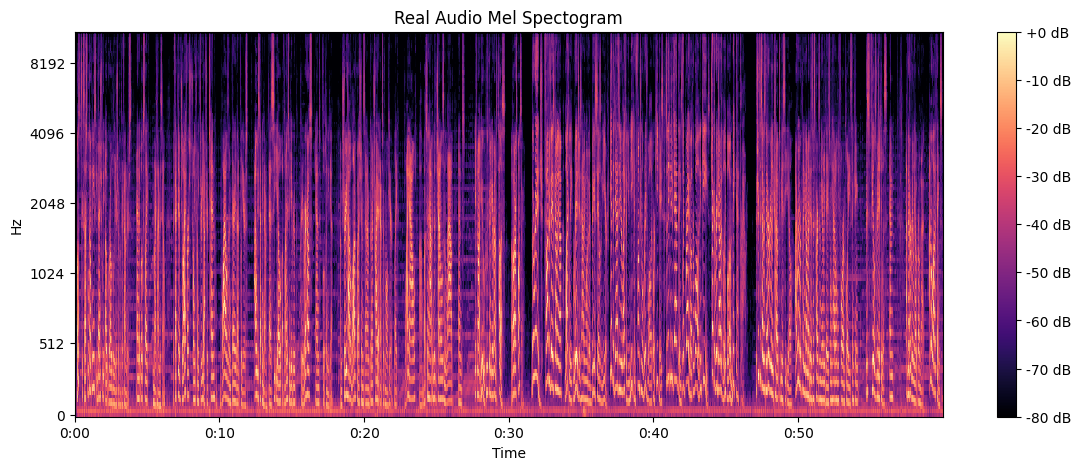

In [12]:
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
plt.title("Real Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

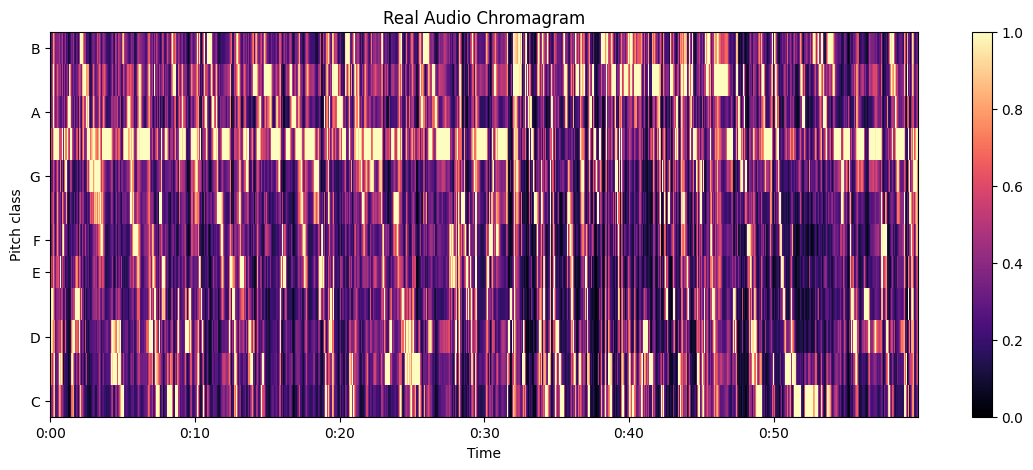

In [13]:
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Real Audio Chromagram")
plt.show()

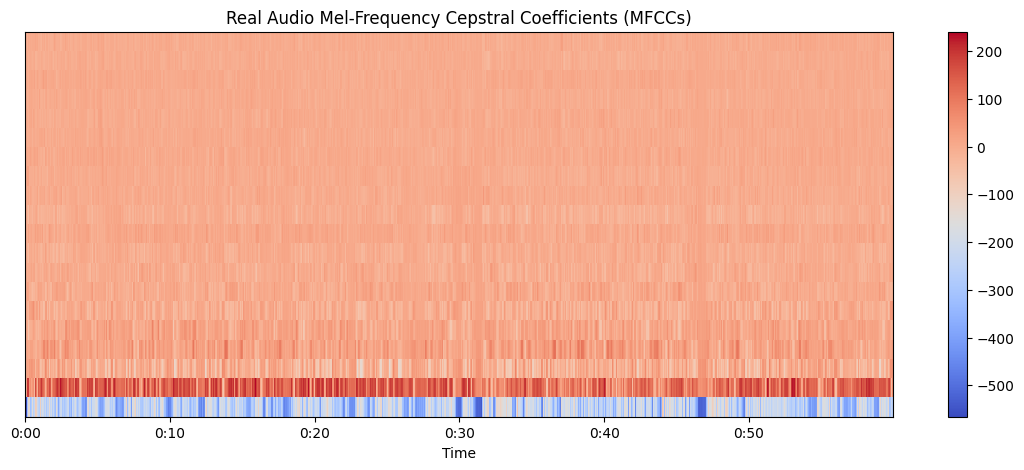

In [14]:
real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
plt.colorbar()
plt.title("Real Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

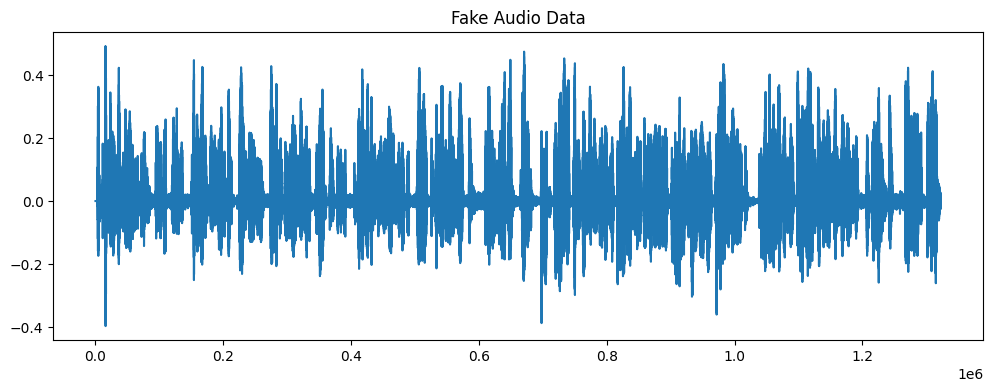

In [15]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize=(12, 4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

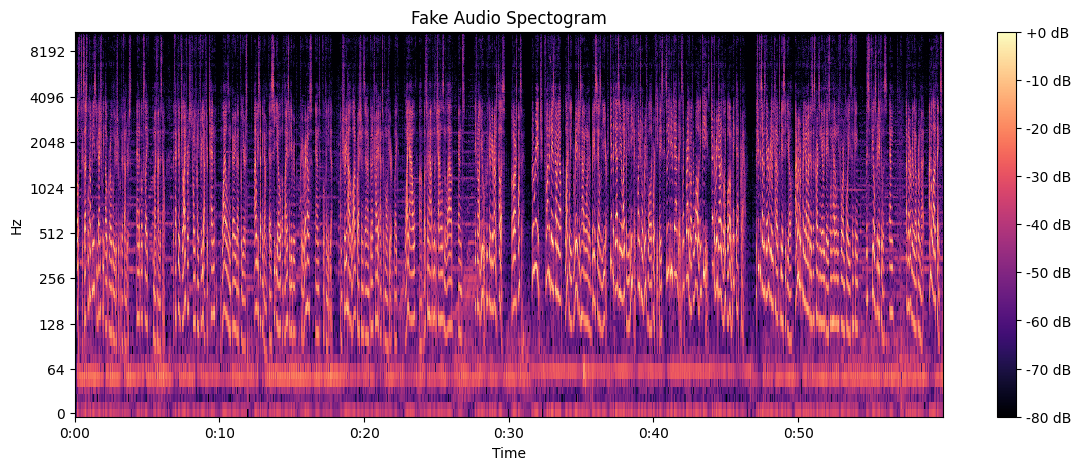

In [16]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.show()

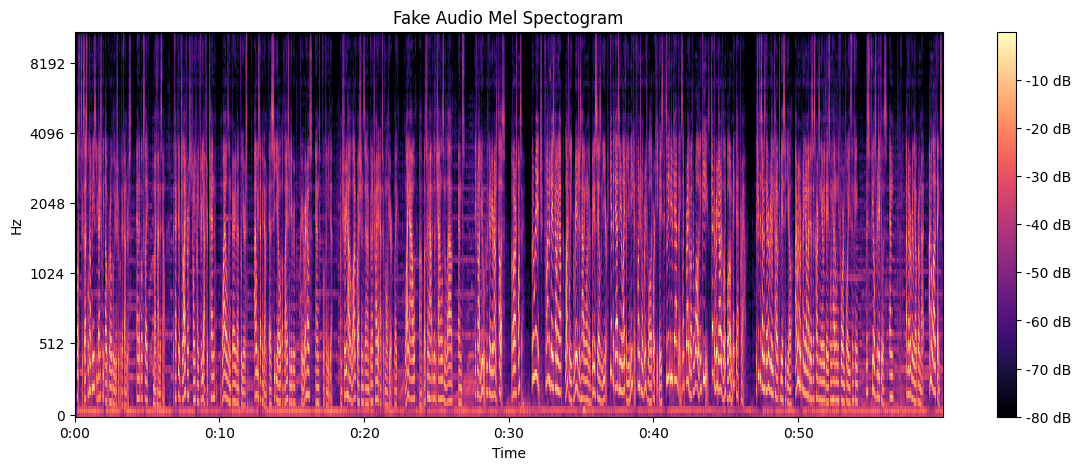

In [17]:
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time")
plt.title("Fake Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

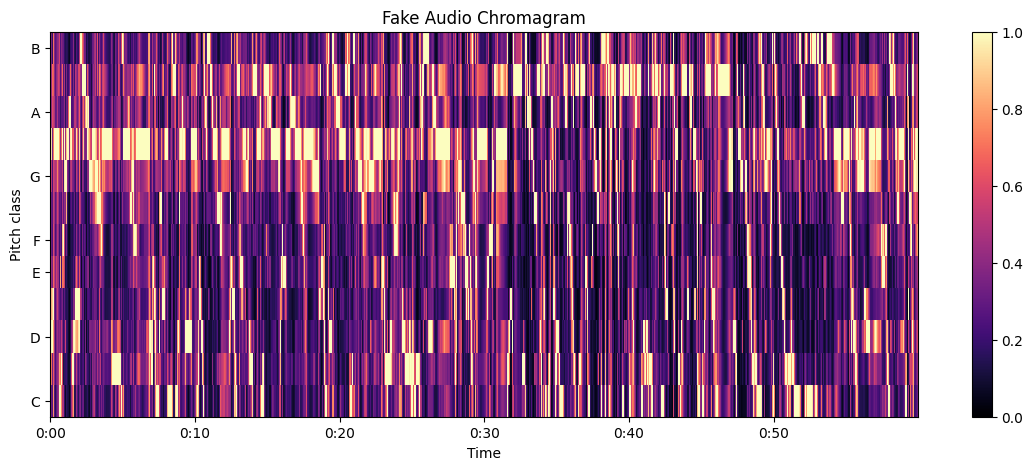

In [18]:
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Fake Audio Chromagram")
plt.show()

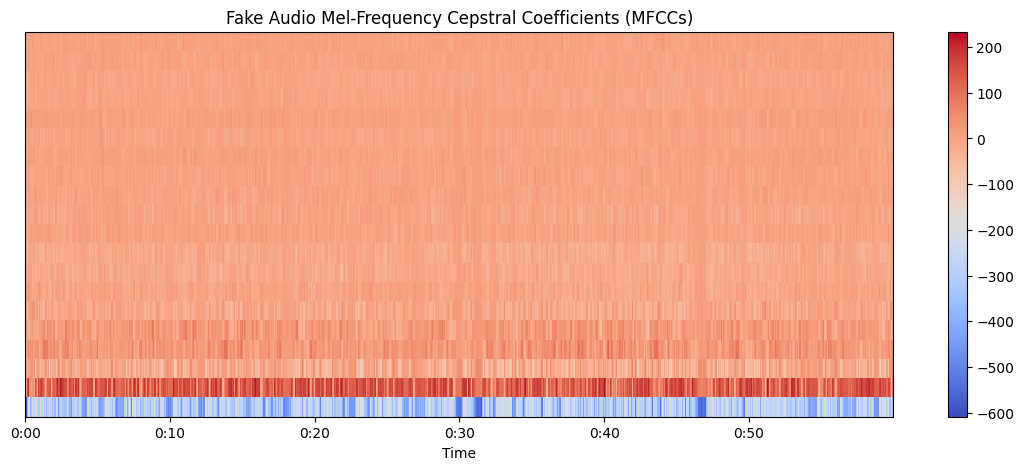

In [19]:
fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time")
plt.colorbar()
plt.title("Fake Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

# Preprocess

In [75]:
data = []
labels = []

for folder in folders:
    files = os.listdir(os.path.join(audio_files_path, folder))
    for file in tqdm(files):
        file_path = os.path.join(audio_files_path, folder, file)
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
        data.append(mfccs_features_scaled)
        labels.append(folder)

100%|██████████| 8/8 [01:00<00:00,  7.52s/it]


In [76]:
feature_df = pd.DataFrame({"features": data, "class": labels})
feature_df.head()

features class
0  [-325.50876, 106.18816, 5.058224, 31.053482, 1...  FAKE
1  [-288.04373, 75.1327, 1.3050721, 20.612984, -2...  FAKE
2  [-332.00537, 58.67164, -17.978699, 12.94961, -...  FAKE
3  [-258.9036, 93.914345, -27.627075, -1.9326237,...  FAKE
4  [-314.47778, 100.20979, -6.4362664, 14.904346,...  FAKE

In [77]:
feature_df["class"].value_counts()

class
FAKE    56
REAL     8
Name: count, dtype: int64

In [78]:
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

In [79]:
feature_df["class"] = label_encoder(feature_df["class"])

class ['FAKE' 'REAL']


# Feature Scaling

In [80]:
X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

In [81]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [82]:
y_resampled = to_categorical(y_resampled)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [84]:
num_labels = len(feature_df["class"].unique())
num_labels

2

In [85]:
input_shape = feature_df["features"][0].shape
input_shape

(40,)

# Model

In [86]:
model = Sequential()
model.add(Dense(128, input_shape=input_shape))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation(activation="softmax"))

In [87]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [88]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               5248      
                                                                 
 activation_12 (Activation)  (None, 128)               0         
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 activation_13 (Activation)  (None, 256)               0         
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 128)              

In [91]:
early = EarlyStopping(monitor="val_loss", patience=5)

In [92]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2, epochs=100, callbacks=[early])

Epoch 1/100
45/45 [==============================] - 0s 4ms/step - loss: 6.4502 - accuracy: 0.5730 - val_loss: 0.4864 - val_accuracy: 0.7826
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 4.8813 - accuracy: 0.5393 - val_loss: 0.4257 - val_accuracy: 0.8696
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 4.8126 - accuracy: 0.5056 - val_loss: 0.6620 - val_accuracy: 0.6087
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 4.2696 - accuracy: 0.4494 - val_loss: 1.6354 - val_accuracy: 0.3478
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 5.8391 - accuracy: 0.4157 - val_loss: 0.5633 - val_accuracy: 0.7826
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 2.9101 - accuracy: 0.5618 - val_loss: 1.1084 - val_accuracy: 0.3478
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 2.4623 - accuracy: 0.5056 - val_loss: 1.0916 - val_accuracy: 0.3478


In [93]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

1/1 [==============================] - 0s 22ms/step - loss: 1.0916 - accuracy: 0.3478
Test Loss: 1.0915780067443848
Test Accuracy: 0.3478260934352875


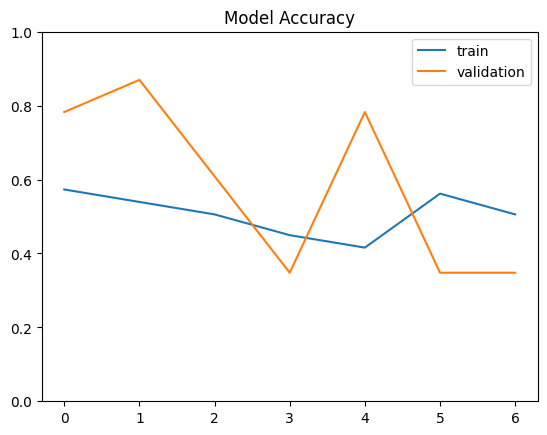

In [94]:
plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

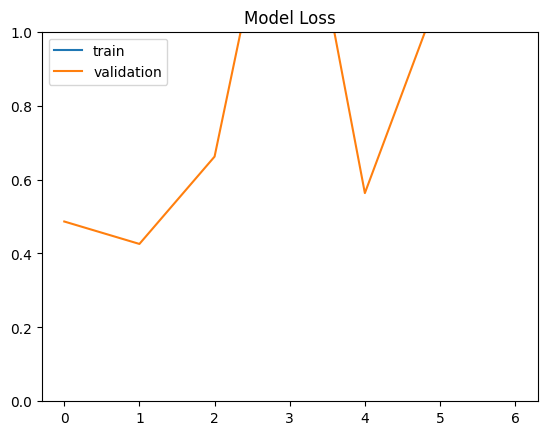

In [95]:
plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# Test

In [96]:
def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = model.predict(mfccs_features_scaled)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])

In [97]:
test_real = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
test_fake = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

In [98]:
detect_fake(test_real)

1/1 [==============================] - 0s 75ms/step
[[0.11386743 0.8861326 ]]
Result: REAL


In [74]:
detect_fake(test_fake)

1/1 [==============================] - 0s 30ms/step
[[0.90279347 0.09720654]]
Result: FAKE
